In [88]:
try:
# %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras import backend as K

import numpy as np
import matplotlib.pyplot as plt
import random
from tensorflow.python.keras.utils.vis_utils import plot_model

In [89]:
from keras.models import Model
from keras.layers import Conv2D, Activation, Input, Add
from keras.layers.core import Dense, Flatten, Dropout
from keras.layers.pooling import MaxPooling2D
myInput = Input(shape=(55, 47, 3))
 
x = Conv2D(20, (4, 4), name='Conv1', activation='relu', input_shape=(160, 160, 3))(myInput)
x = MaxPooling2D(pool_size=2, strides=2, name='Pool1')(x)
x = Dropout(rate=1, name='D1')(x)
 
x = Conv2D(40, (3, 3), name='Conv2', activation='relu')(x)
x = MaxPooling2D(pool_size=2, strides=2, name='Pool2')(x)
x = Dropout(rate=1, name='D2')(x)
 
x = Conv2D(60, (3, 3), name='Conv3', activation='relu')(x)
x = MaxPooling2D(pool_size=2, strides=2, name='Pool3')(x)
x = Dropout(rate=1, name='D3')(x)
 
x1 = Flatten()(x)
fc11 = Dense(160, name = 'fc11')(x1)
 
x2 = Conv2D(80, (2, 2), name='Conv4', activation='relu')(x)
x2 = Flatten()(x2)
fc12 = Dense(160, name = 'fc12')(x2)
 
y = Add()([fc11, fc12])
y = Activation('relu', name = 'deepid')(y)
 
model = Model(inputs=[myInput], outputs=y)

In [90]:
model.load_weights("deepid_keras_weights.h5")

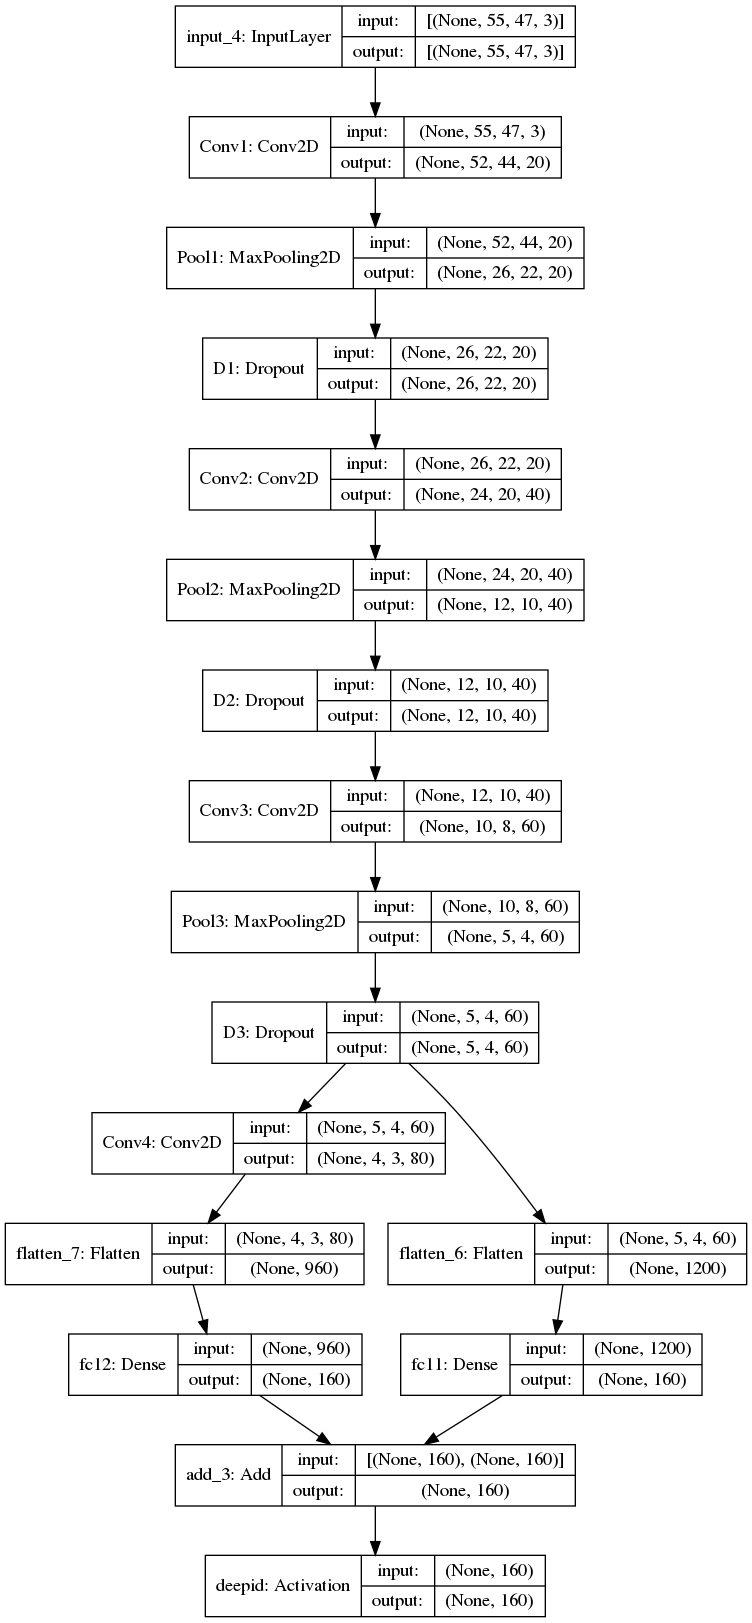

In [91]:
plot_model(model, show_shapes=True, show_layer_names=True, to_file='outer-model.png')

In [92]:
def create_pairs(x, digit_indices, distinct_labels_length):
    '''Positive and negative pair creation.
    Alternates between positive and negative pairs.
    '''
    pairs = []
    labels = []
    n = min([len(digit_indices[d]) for d in range(distinct_labels_length)]) - 1
    
    for d in range(distinct_labels_length):
        if len(digit_indices[d]) > 1:
            for i in range(len(digit_indices[d]) - 1):
                z1, z2 = digit_indices[d][i], digit_indices[d][i + 1]
                pairs += [[x[z1], x[z2]]]
                inc = random.randrange(1, distinct_labels_length)
                dn = (d + inc) % distinct_labels_length
                random_index =  random.randrange(1, len(digit_indices[dn]))
                z1, z2 = digit_indices[d][i], digit_indices[dn][random_index]
                pairs += [[x[z1], x[z2]]]
                labels += [1, 0]
            
    return np.array(pairs), np.array(labels)


def create_pairs_on_set(images, labels, distinct_labels_length):
    
    digit_indices = [np.where(labels == i)[0] for i in range(distinct_labels_length)]
    pairs, y = create_pairs(images, digit_indices, distinct_labels_length)
    y = y.astype('float32')
    
    return pairs, y


def show_image(image):
    plt.figure()
    plt.imshow(image.astype("uint8"))
    plt.colorbar()
    plt.grid(False)
    plt.show()

In [93]:
import numpy as np
data = np.load('5-celebrity-faces-dataset-deepid.npz')
trainX, trainy, testX, testy = data['arr_0'], data['arr_1'], data['arr_2'], data['arr_3']
print('Loaded: ', trainX.shape, trainy.shape, testX.shape, testy.shape)

Loaded:  (93, 55, 47, 3) (93,) (25, 55, 47, 3) (25,)


In [94]:
from sklearn.preprocessing import LabelEncoder
out_encoder = LabelEncoder()
out_encoder.fit(trainy)
trainy = out_encoder.transform(trainy)
out_encoder = LabelEncoder()
out_encoder.fit(testy)
testy = out_encoder.transform(testy)

In [95]:
from sklearn.preprocessing import LabelEncoder
out_encoder = LabelEncoder()
out_encoder.fit(trainy)
trainy = out_encoder.transform(trainy)
testy = out_encoder.transform(testy)

In [96]:
images, labels=(trainX, trainy)

In [97]:
#images = np.array([image for image in images])
#mean, std = images.mean(), images.std()
#images = (images - mean)/std 
#print(images.shape)
tr_pairs, tr_y = create_pairs_on_set(images, labels, 5)

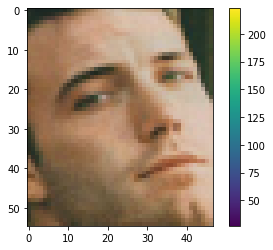

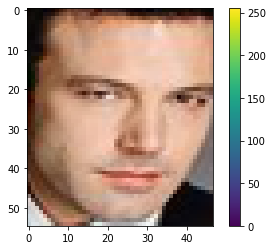

1.0


In [98]:
# array index
this_pair = 8

# show images at this index
show_image(tr_pairs[this_pair][0])
show_image(tr_pairs[this_pair][1])

# print the label for this pair
print(tr_y[this_pair])

In [99]:
def get_embedding(model, face_pixels):
	# scale pixel values
	face_pixels = face_pixels.astype('float32')
	# standardize pixel values across channels (global)
	mean, std = face_pixels.mean(), face_pixels.std()
	face_pixels = (face_pixels - mean) / std
	# transform face into one sample
	samples = tf.expand_dims(face_pixels, axis=0)
	# make prediction to get embedding
	yhat = model.predict(samples)
	return yhat[0]

In [100]:
def euclidean_distance(vects):
    x, y = vects
    sum_square = K.sum(K.square(x - y), axis=1, keepdims=True)
    return K.sqrt(sum_square)

def l2_normalize(x):
    return x / np.sqrt(np.sum(np.multiply(x, x)))

In [101]:
def findCosineDistance(source_representation, test_representation):
    a = np.matmul(np.transpose(source_representation), test_representation)
    b = np.sum(np.multiply(source_representation, source_representation))
    c = np.sum(np.multiply(test_representation, test_representation))
    return 1 - (a / (np.sqrt(b) * np.sqrt(c)))

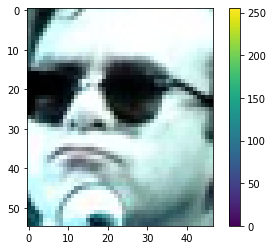

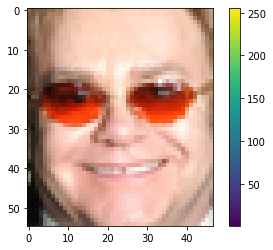

1.0
(160,)
(160,)
tf.Tensor([[772.3492]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.92434233]], shape=(1, 1), dtype=float32)
0.4272043704986572


In [165]:
# array index
this_pair = 52

# show images at this index
show_image(tr_pairs[this_pair][0])
show_image(tr_pairs[this_pair][1])

# print the label for this pair
print(tr_y[this_pair])
x = get_embedding(model, tr_pairs[this_pair][0])
print(x.shape)

y = get_embedding(model, tr_pairs[this_pair][1])
print(y.shape)

print(euclidean_distance([x.reshape(1, 160), y.reshape(1, 160)]))
print(euclidean_distance([l2_normalize(x.reshape(1, 160)), l2_normalize(y.reshape(1, 160))]))
print(findCosineDistance(x, y))

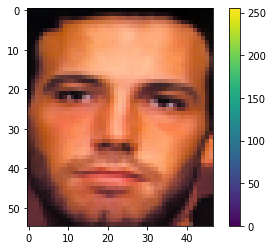

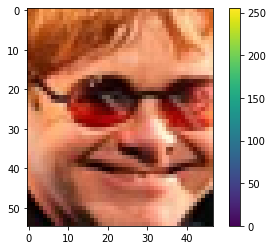

0.0
(160,)
(160,)
tf.Tensor([[651.6984]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.96202546]], shape=(1, 1), dtype=float32)
0.46274644136428833


In [154]:
# array index
this_pair = 13

# show images at this index
show_image(tr_pairs[this_pair][0])
show_image(tr_pairs[this_pair][1])

# print the label for this pair
print(tr_y[this_pair])
x = get_embedding(model, tr_pairs[this_pair][0])
print(x.shape)

y = get_embedding(model, tr_pairs[this_pair][1])
print(y.shape)

print(euclidean_distance([x.reshape(1, 160), y.reshape(1, 160)]))
print(euclidean_distance([l2_normalize(x.reshape(1, 160)), l2_normalize(y.reshape(1, 160))]))
print(findCosineDistance(x, y))

In [104]:
model.save("Deepid saved model.h5")

/home/arnab/anaconda3/envs/tensorrt/lib/python3.6/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [128]:
from PIL import Image
from numpy import asarray
from mtcnn.mtcnn import MTCNN

def extract_face(filename, required_size=(47, 55)):
    # load image from file
    image = Image.open(filename)
    # convert to RGB, if needed
    image = image.convert('RGB')
    # convert to array
    pixels = asarray(image)
    # create the detector, using default weights
    detector = MTCNN()
    # detect faces in the image
    results = detector.detect_faces(pixels)
    # extract the bounding box from the first face
    x1, y1, width, height = results[0]['box']
    # bug fix
    x1, y1 = abs(x1), abs(y1)
    x2, y2 = x1 + width, y1 + height
    # extract the face
    face = pixels[y1:y2, x1:x2]
    # resize pixels to the model size
    image = Image.fromarray(face)
    image = image.resize(required_size)
    face_array = asarray(image)
    return face_array

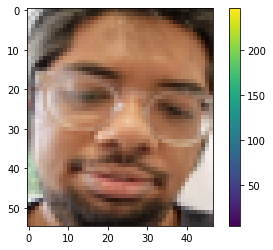

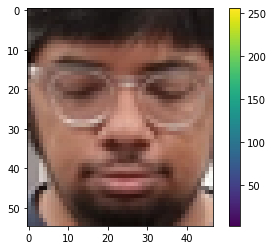

tf.Tensor([[481.8179]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.6326826]], shape=(1, 1), dtype=float32)
0.2001436948776245


In [179]:
left_face = extract_face('test/1.jpg')
show_image(left_face)
x = get_embedding(model, left_face)
right_face = extract_face('test/2.jpg')
show_image(right_face)
y = get_embedding(model, right_face)
print(euclidean_distance([x.reshape(1, 160), y.reshape(1, 160)]))
print(euclidean_distance([l2_normalize(x.reshape(1, 160)), l2_normalize(y.reshape(1, 160))]))
print(findCosineDistance(x, y))